In [25]:
from musicparser.data_loading import JTBDataset
import wandb
from musicparser.data_loading import JTBDataModule
from musicparser.models import ArcPredictionLightModel
from musicparser.postprocessing import eisner_fast, eisner_slow
from pytorch_lightning import Trainer
import os
import torch
import numpy as np

/share/home/francesco/miniconda3/envs/musicparser/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'eisner_slow' from 'musicparser.postprocessing' (/share/home/francesco/musicparser/musicparser/postprocessing.py)

In [2]:
dataset = JTBDataset("data/jazz_tb/treebank.json", data_augmentation="preprocess", only_tree=True, tree_type="open",n_jobs=1)

Loading open tree data...
Done loading data. 0 out of 150 pieces were discarded because of errors.


In [3]:
dataset.titles[8]

'Blue In Green'

In [4]:
dataset.chords_features[8].shape

(16, 5)

In [5]:
# run = wandb.init()
# artifact = run.use_artifact('fosfrancesco/loo_JTB/model-go1417zv:v0', type='model')
# artifact_dir = artifact.download()

artifact_dir = "artifacts/model-go1417zv:v0"

In [45]:
datamodule = JTBDataModule(batch_size=1, num_workers=1, data_augmentation="preprocess", only_tree=True, loo_index=8)
datamodule.setup()
model = ArcPredictionLightModel.load_from_checkpoint(checkpoint_path=os.path.join(os.path.normpath(artifact_dir), "model.ckpt"))

wandb_logger = True

trainer = Trainer(
    max_epochs=60, accelerator="auto", devices= [0], #strategy="ddp",
    num_sanity_val_steps=1,
    logger=wandb_logger,
    deterministic=True
    )

# trainer.tune(model, datamodule=datamodule)
# print("LR set to", model.lr)
out_dict= trainer.predict(model, dataloaders=datamodule.test_dataloader())[0]

Loading complete tree data...
Done loading data. 0 out of 150 pieces were discarded because of errors.
Augmenting data...
Augmenting data...
Train size :1788, Val size :1, Test size :1
No pretraining data


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/share/home/francesco/miniconda3/envs/musicparser/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [20]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs(path = "fosfrancesco/sweeps_JTB")
# filters={"config.group": "LOO1"}

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
        if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

In [23]:
runs_df["summary"][0]

{'epoch': 60,
 'test_ctrees': {'_type': 'table-file',
  'ncols': 2,
  'nrows': 1,
  'sha256': '742bb1ea839f0cbf52ed9e8245bd0aee409171d7d56846f84a472d6e7c9e0f7a',
  'artifact_path': 'wandb-client-artifact://4t2m2q1w42c5ysyv54wvg6hgzio2qremiq7s3x0hxvl6kz4e8roq4k8r253fs7lkske93db6f8fxtciajt8bdco308spxr1609o6or38nvljnc5r77tb8c117zvc0xk1:latest/test_ctrees.table.json',
  '_latest_artifact_path': 'wandb-client-artifact://4t2m2q1w42c5ysyv54wvg6hgzio2qremiq7s3x0hxvl6kz4e8roq4k8r253fs7lkske93db6f8fxtciajt8bdco308spxr1609o6or38nvljnc5r77tb8c117zvc0xk1:latest/test_ctrees.table.json',
  'path': 'media/table/test_ctrees_4533_742bb1ea839f0cbf52ed.table.json',
  'size': 492},
 'test_head_seqs': {'ncols': 3,
  'nrows': 1,
  'sha256': '6a1fc272f7dbcc0fe8e7160f40c12d3dca28ad7dcdd539cbd595a1fc16619f30',
  'artifact_path': 'wandb-client-artifact://4v642fo375lygoqegmzd80oe7vbb6dntzxpad1m6nrwyj33ydkxw2dspvptp6wpjf4d78j3j2mnzs6rqoeiykj1m59qzgyetph63ymkgjp0wi62z9s3owwp35wmb6rmb:latest/test_head_seqs.table.jso

In [30]:
dataset =JTBDataset("data/jazz_tb/treebank.json", data_augmentation="preprocess", only_tree=True, tree_type="open",n_jobs=1)
chords = dataset.chords_features 
titles = dataset.titles
df = pd.DataFrame({
    "len": [len(c) for c in chords],
    "titles": titles,
    })

df.to_csv("len.csv")

Loading open tree data...
Done loading data. 0 out of 150 pieces were discarded because of errors.


In [33]:
import seaborn as sns
import pandas as pd

In [45]:
df = pd.read_csv("FormattedResults.csv")

In [46]:
df

,Accuracy,Model,Value
0,Arc,Harasim,0.750
1,Arc,Harasim,1.000
2,Arc,Harasim,1.000
3,Arc,Harasim,1.000
4,Arc,Harasim,0.917
...,...,...,...
745,Head,MuDeP,0.743
746,Head,MuDeP,0.943
747,Head,MuDeP,0.919
748,Head,MuDeP,0.784


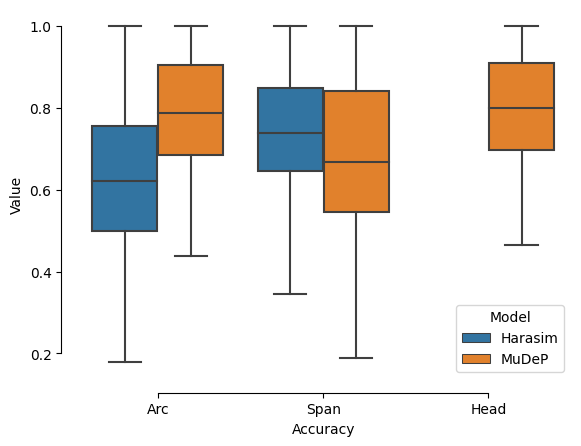

In [49]:

# Load the example tips dataset
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Accuracy", y="Value",
            hue="Model",
            data=df)
sns.despine(offset=10, trim=True)

In [38]:
tips = sns.load_dataset("tips")

In [39]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
